In [1]:
%load_ext autoreload
%autoreload 2

# standard stuff
import os
import pandas as pd
import numpy as np
np.random.seed(123)
import json
import pickle 
from tqdm import tqdm
import datetime as dt
from collections import Counter
from time import time

# text processing
import spacy
nlp = spacy.load('de')
from  nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("german")

# visualization 
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
sns.set()
import plotly as py
import plotly.graph_objs as go
py.offline.init_notebook_mode(connected=True)

# Gensim LDA
from gensim import corpora
from gensim.models import LdaModel, CoherenceModel
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

# custom imports
from data_handling import load_data, collapse_dfs
from text_preprocessing import df_processing, party_remover
from lda_functions import dict_pruning, party_substituter, sparse_text

In [16]:
read_in = False
path = '/home/franzi/Git-DSR/Twitter_sentimentanalysis/Data/lda_data.pickle'
parties = ['AfD', 'SPD', 'CDU', 'CSU', 'FDP', 'LINKE', 'Gruene', 'Grüne']
dates = ['08-{:02d}'.format(3)]


if read_in:
    parties = parties
    dates = dates
    aug_data = {}
    print('Loading: {}'.format(dates))
    for party in parties:
        load_list = ['../Data/{}/{}_2018-{}.json'.format(party, party, day) for day in dates]
        aug_data[party] = load_data(load_list)
        print('{} loaded'.format(party))
    with open(path, 'wb') as fid:
        pickle.dump(aug_data, fid)
    print("Done")
else:
    print('loading data from pickle')
    with open(path, 'rb') as fid:
        aug_data = pickle.load(fid)
        print('data loaded')

  0%|          | 0/1 [00:00<?, ?it/s]

Loading: ['08-03']


/home/franzi/Git-DSR/Twitter_sentimentanalysis/Scripts/data_handling.py:34: FutureWarning:

'created_at' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version

  0%|          | 0/1 [00:00<?, ?it/s]

AfD loaded


/home/franzi/Git-DSR/Twitter_sentimentanalysis/Scripts/data_handling.py:34: FutureWarning:

'created_at' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version

  0%|          | 0/1 [00:00<?, ?it/s]

SPD loaded


/home/franzi/Git-DSR/Twitter_sentimentanalysis/Scripts/data_handling.py:34: FutureWarning:

'created_at' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version

  0%|          | 0/1 [00:00<?, ?it/s]

CDU loaded


/home/franzi/Git-DSR/Twitter_sentimentanalysis/Scripts/data_handling.py:34: FutureWarning:

'created_at' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version

  0%|          | 0/1 [00:00<?, ?it/s]

CSU loaded


/home/franzi/Git-DSR/Twitter_sentimentanalysis/Scripts/data_handling.py:34: FutureWarning:

'created_at' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version

  0%|          | 0/1 [00:00<?, ?it/s]

FDP loaded


/home/franzi/Git-DSR/Twitter_sentimentanalysis/Scripts/data_handling.py:34: FutureWarning:

'created_at' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version

  0%|          | 0/1 [00:00<?, ?it/s]

LINKE loaded


/home/franzi/Git-DSR/Twitter_sentimentanalysis/Scripts/data_handling.py:34: FutureWarning:

'created_at' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version

  0%|          | 0/1 [00:00<?, ?it/s]

Gruene loaded


/home/franzi/Git-DSR/Twitter_sentimentanalysis/Scripts/data_handling.py:34: FutureWarning:

'created_at' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version

100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


Grüne loaded
Done


In [17]:
collapse = False
path_collapse = '/home/franzi/Git-DSR/Twitter_sentimentanalysis/Data/all_data_lda_1day.pickle' # path where pickle file is saved

if collapse:
    all_data = collapse_dfs(aug_data)
    df_processing(all_data)
    all_data = all_data.drop_duplicates('clean_text')
    all_data['user_id'] = all_data.loc[:, 'user'].map(lambda x: x['id_str'])
    all_data.drop('user', inplace=True, axis=1)
    print('dumping data to pickle')
    with open(path_collapse, 'wb') as fid:
        pickle.dump(all_data, fid)
    print('data dumped')
else: 
    print('loading data from pickle')
    with open(path_collapse, 'rb') as fid:
        all_data = pickle.load(fid)
        print('data loaded')

dumping data to pickle
data dumped


# LDA using gensim 

- take only with certin 'tags' from clean text: nouns, verbs, adverbs, adjectives
    - substitute party acronyms (SPD: sozialdemokraten, CDU: christdemokraten, CSU: christoziale, FDP: freidemokraten, Afd: pfannen(unfortunately, using 'alternative' as substitute might intervene with the commonly used word or even with the politically more leftist alternatives that are not quite punks yet; using some cooking tool should be save)) 
    - make them lower-case
    - take only words longer than 2 characters
    - stem them
- prepare a common dictionary
- prepare common corpus with vectorized (bow) words
- run through a couple of topics numbers and look at metrics: coherence score and model perplexity
    -> chose number of topics where metrics look best
- run lda on corpus, evaluate model and visualize it

In [23]:
save = True

path_com_corpus = '../Data/lda_nlp_stem_ccorpus_1day.pkl'
path_corpus = '../Data/lda_nlp_stem_corpus_1day.pkl'
path_dic = '../Data/lda_nlp_stem_dic_1day.pkl'

if save:
    text = all_data.loc[:, 'clean_text'].map(lambda x: x.lower()).map(party_substituter)

    document = []

    for row in text.iteritems():
        index, data = row
        document.append(data)
    
    lengths = len(document)
    corpus = []
    tick = time()
    for i, term in enumerate(document):
        corpus.append(sparse_text(term, nlp))
        print('{}/{}'.format(i, lengths), end='\r')
        if i % 5000 == 0:
            t1 = (time() - tick)/60
            print('Took {:.2f} min for {} loops'.format(t1, i))
    print('The entire process took {:.2f} min'.format((time() - tick)/60))


    common_dictionary = corpora.Dictionary(corpus, prune_at=100000)

    common_corpus = [common_dictionary.doc2bow(row) for row in corpus]

    
    with open(path_com_corpus, 'wb') as fid:
        pickle.dump(common_corpus, fid)
    with open(path_dic, 'wb') as fid:
        pickle.dump(common_dictionary, fid)
    with open(path_corpus, 'wb') as fid:
        pickle.dump(corpus, fid)       

else:
    with open(path_com_corpus, 'rb') as fid:
        common_corpus = pickle.load(fid)
    with open(path_dic, 'rb') as fid:
        common_dictionary = pickle.load(fid)
    with open(path_corpus, 'rb') as fid:
        corpus = pickle.load(fid)

Took 0.00 min for 0 loops
Took 2.75 min for 5000 loops
Took 5.66 min for 10000 loops
Took 8.14 min for 15000 loops
The entire process took 9.27 min


<Figure size 720x2160 with 0 Axes>

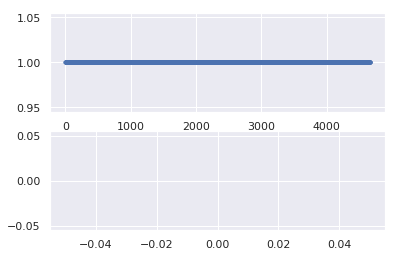

In [20]:
def corpus_wordcount(corpus, full_corpus):
    """
    visualizes how the number of low-frequency words changes after pruning the dictionary
    """
    
    flat_list = [item for sublist in corpus for item in sublist]
    full_flat_list = [item for sublist in full_corpus for item in sublist]
    cntr = Counter(flat_list)
    full_cntr = Counter(full_flat_list)
    
    fig = plt.figure(figsize=(10, 30))
    fig, (ax1, ax2) = plt.subplots(2, 1)
    ax1.plot(sorted(full_cntr.values())[:-5000], '.')
    ax2.plot(sorted(cntr.values())[:-5000], '.')
    plt.show()

corpus_wordcount(corpus=corpus, full_corpus=corpus_full)

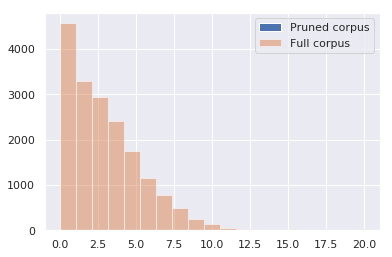

In [21]:
def document_wordcount(corpus, full_corpus):
    """
    visualizes how long the tweets are before and after pruning the dictionary
    """
    
    plt.hist([len(x) for x in corpus], bins=np.linspace(0,20,20), label='Pruned corpus')
    plt.hist([len(x) for x in full_corpus], bins=np.linspace(0,20,20), label='Full corpus', alpha=0.5)
    plt.legend()
    plt.show()

document_wordcount(corpus=corpus, full_corpus=corpus_full)

Process took 1.3214689056078592 min


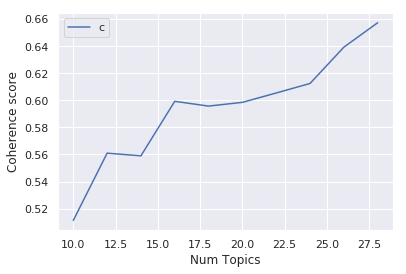

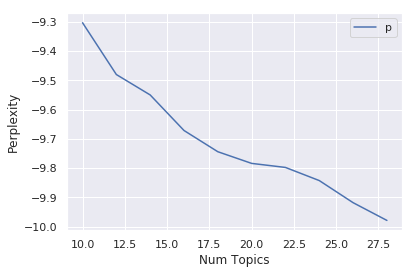

In [27]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute coherence for various number of topics

    Parameters:
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Plots coherence score over number of topics
    """
    tick = time()
    coherence_values = []
    model_list = []
    perplexity_values = []
    for num_topics in range(start, limit, step):
        model=LdaModel(corpus=corpus, 
                       id2word=dictionary, 
                       num_topics=num_topics, 
                       alpha=0.001, 
                       minimum_probability=0.2,
                       iterations=10)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        perplexity_values.append(model.log_perplexity(common_corpus))
    print('Process took {} min'.format((time()-tick)/60))
        
    x = range(start, limit, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Num Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()

    plt.plot(x, perplexity_values)
    plt.xlabel("Num Topics")
    plt.ylabel("Perplexity")
    plt.legend(("perplexity"), loc='best')
    plt.show()

compute_coherence_values(common_dictionary, common_corpus, corpus, limit=30, start=10, step=2)

Following from coherence score curve
- choose 22 topics: highest coherence score before curve flattens out 
- given the corpus 20 topics make more sense than 80 - this can also be seen in the LDA visualization: with 80 topics, most of them cluster in the lower-right corner

Following from LDA visualization
- comparing topic-bubbles of different numbers of topics: chosing 17 topics results in nicely distributed, hardly overlapping clusters

In [30]:
lda = LdaModel(common_corpus, 
               num_topics=15, 
               id2word=common_dictionary, 
               alpha=0.001,
               passes=5,
               random_state=123, 
               minimum_probability=0.2,
               per_word_topics=True,
               iterations=70)

# Compute Coherence Score using c_v
coherence_model_lda = CoherenceModel(model=lda, texts=corpus, dictionary=common_dictionary, coherence='c_v')

coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score c_v: ', coherence_lda)

# Compute Coherence Score using u-mass
coherence_model_lda = CoherenceModel(model=lda, texts=corpus, dictionary=common_dictionary, coherence='u_mass')

coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score u-mass: ', coherence_lda)

perplexity = lda.log_perplexity(common_corpus)
print('Model perplexity: ', perplexity)

ldavis_prepared = pyLDAvis.gensim.prepare(lda, common_corpus, common_dictionary)

pyLDAvis.display(ldavis_prepared)

Coherence Score c_v:  0.6026913818696589
Coherence Score u-mass:  -16.474744341200378
Model perplexity:  -9.320869681839218


/home/franzi/miniconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




https://nlp.stanford.edu/events/illvi2014/papers/sievert-illvi2014.pdf

- A topic in LDA is a multinomial distribution over the (typically thousands of) terms in the vocabulary of the corpus. 

In [26]:
save_model = True
path = '../Models/lda_nlp_stemmed_lda-model83.pkl'
if save_model:
    with open(path, 'wb') as fid:
        pickle.dump(lda, fid)
else:
    with open(path, 'rb') as fid:
        lda = pickle.load(fid)

In [17]:
def format_topics_sentences(ldamodel, corpus, texts):
    
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row[0], key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [18]:
save_topics = True
path = '../Data/lda_nlp_stemmed_lda_topics.pkl'

if save_topics:   
    df_topic_sents_keywords = format_topics_sentences(ldamodel=lda, corpus=common_corpus, texts=corpus)
    # Format
    df_dominant_topic = df_topic_sents_keywords.reset_index()
    df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

    
    # reindex the initial dataframe, make list of initial df and topics df and concatenate both
    all_data_reindexed = all_data.reset_index(drop=True)
    df_list = [df_dominant_topic,all_data_reindexed]
    full_df = pd.concat(df_list, axis=1)
    # make the resulting dataframe datetime indexed again and throw away unwanted columns
    full_df.index = full_df['created_at']
    full_df['topic'] = full_df['Dominant_Topic'].map(lambda x: x.replace('nan', np.NaN) if isinstance(x, str) else x)
    full_df = full_df.drop(['stemmed', 'tags', 'parties', 'created_at', 'mentions'], axis=1)
    # show
    full_df.head()

    with open(path, 'wb') as fid:
        pickle.dump(full_df, fid)

else:
    with open(path, 'rb') as fid:
        full_df = pickle.load(fid)

In [26]:
all_data_reindexed.shape

(115745, 8)

In [27]:
full_df.head()

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,full_text,clean_text,user_id,topic
created_at,,,,,,,,,
2018-08-02 00:00:14,0,8.0,0.5794,"freidemokrat, christsozial, christdemokrat, li...","[migrant, fluechtling, christsozial, christsoz...",@BILD Für Sami A macht man Rundflüge. gute Mig...,Fuer Sami A macht man Rundfluege gute ...,884513792062881794,8.0
2018-08-02 00:00:32,1,26.0,0.4806,"off, normal, argument, schwaech, insgesamt, gr...","[nopfann, argument]",@bembelpix @AfD_Hessen NoAFD schreiben aber ke...,NoAFD schreiben aber keine Argumente li...,702527680722419712,26.0
2018-08-02 00:00:32,2,70.0,0.9243,"zukunft, illegal, rein, gespraech, ministerin,...",[wuerttemberg],RT @Walnusskipferl: @AssetsKater72 @dr_ecksack...,Ich kenne nur die REPs Baden Wuer...,3438043463,70.0
2018-08-02 00:01:33,3,17.0,0.9243,"umfrag, aussag, monat, allgemein, frau, denk, ...",[dritt],@NeotherealNeo @vonduessel @AfD @AndreasKalbit...,Drittens in kauf nehmen ist ungleich ...,846319908254367744,17.0
2018-08-02 00:02:08,4,68.0,0.9243,"merkel, wert, toll, ziel, bundeswehr, ebenfall...",[wert],Damit wir die Werte #AfD besser verstehen. #Af...,Damit wir die Werte AfD besser verstehe...,165708897,68.0


In [23]:
len(corpus)

115745

In [25]:
all_data.shape

(115745, 8)

In [22]:
df_dominant_topic.shape

(115745, 5)

In [19]:
topic_counts = full_df.groupby(full_df.index.date)['topic'].value_counts().reset_index(name='counts')

topic_counts = topic_counts.set_index(pd.DatetimeIndex(topic_counts['level_0'])).drop(columns='level_0')

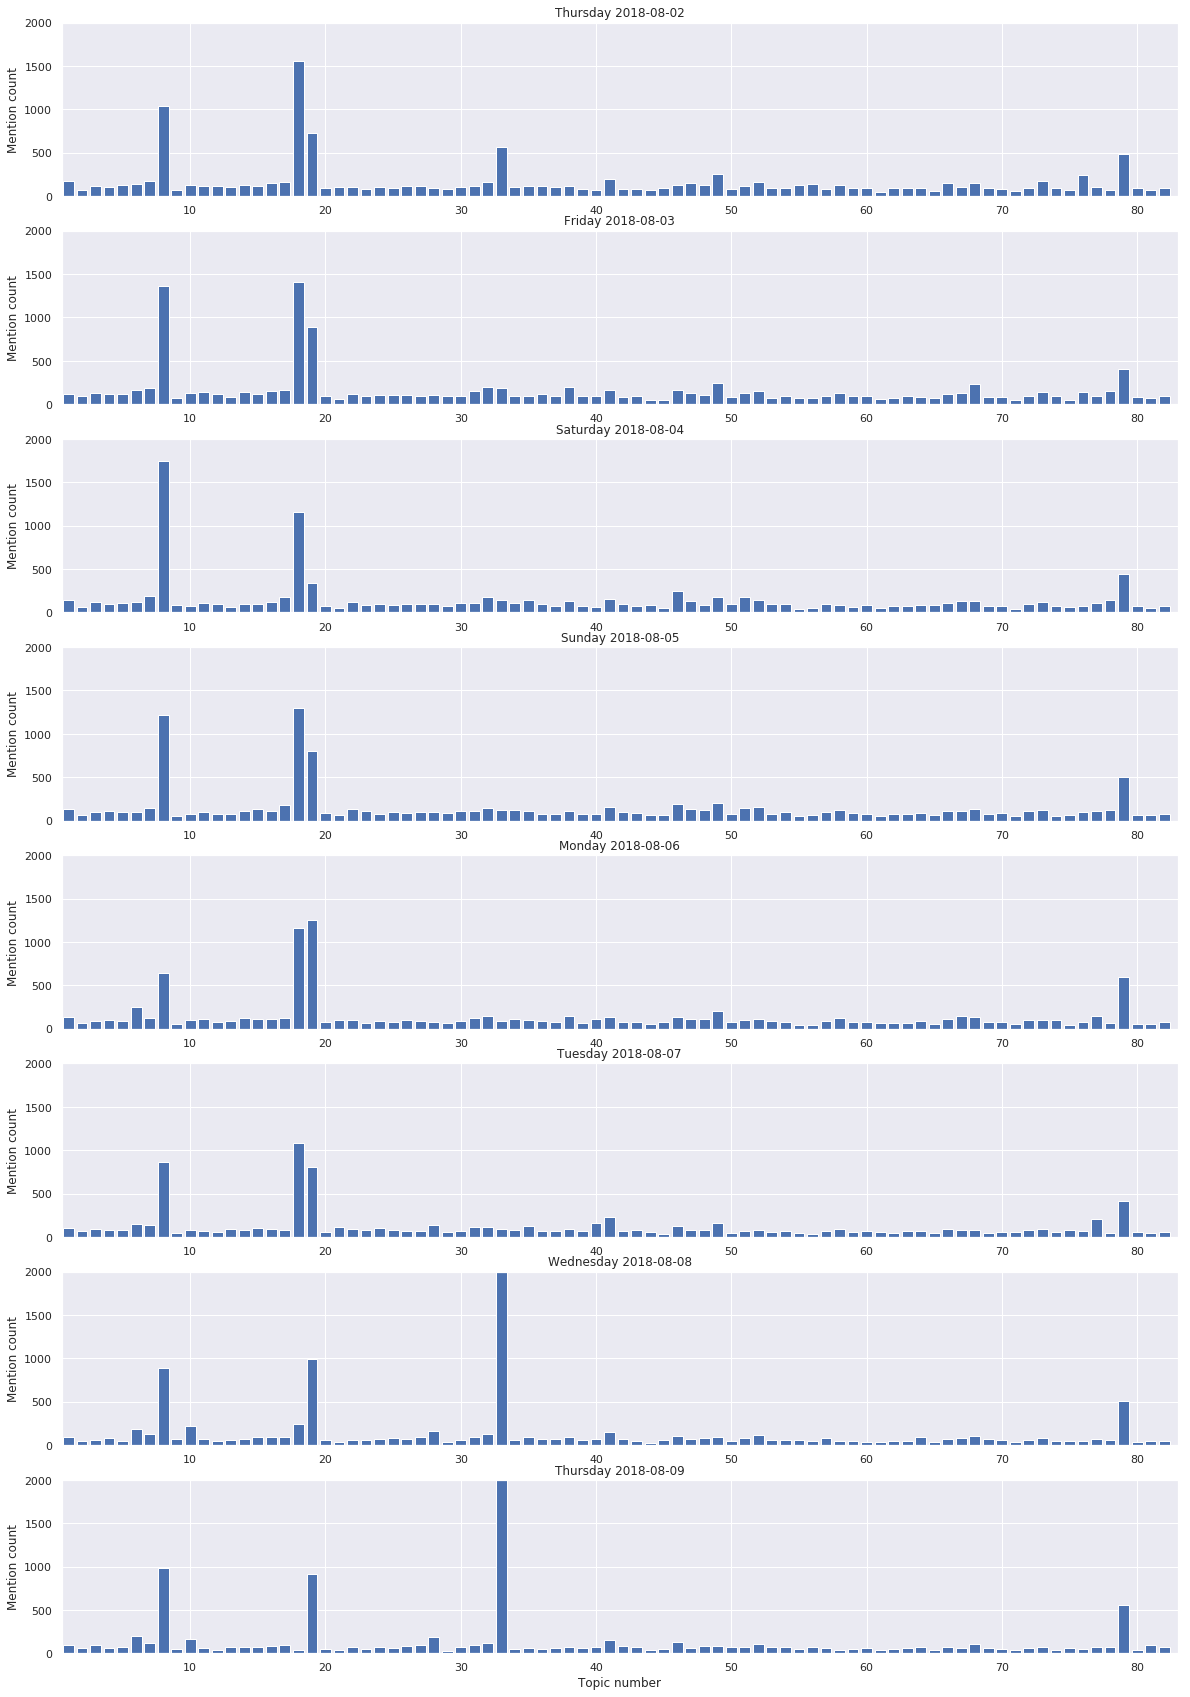

In [20]:
def topic_plot(df):
    dow = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    dates = df.index.unique()
    
    fig, ax = plt.subplots(len(dates), 1, figsize=(20, 30))

    for i, date in enumerate(dates):
        ax[i].bar(df.loc[date, 'topic'], df.loc[date, 'counts'], label=date) 
        ax[i].set_ylim(0, 2000)
        ax[i].set_title('{} {}'.format(dow[date.dayofweek], date.date()))
        ax[i].set_ylabel('Mention count')
        ax[i].set_xlim(0.5, len(df['topic'].unique()))
    plt.xlabel('Topic number')
    plt.show()

topic_plot(topic_counts)

In [21]:
def print_largest_topics(topicsdf, fulldf, topic_prob=0.85, n_text=5):
    largest_tpcs = topicsdf.copy().reset_index().reset_index()
    frequent_topcs = largest_tpcs.groupby('level_0')['counts'].nlargest(5).reset_index().merge(
                 largest_tpcs[['index', 'topic']], left_on='level_1', right_on='index').drop(
                 columns='level_1')
    frequent_topcs_list = frequent_topcs.topic.unique()
    
    for topic in frequent_topcs_list:
        print(topic, fulldf[['Keywords']][fulldf['topic'] == topic].values[0])
        print(fulldf[['Topic_Perc_Contrib', 'clean_text']][(fulldf['topic'] == topic) & (fulldf['Topic_Perc_Contrib'] > topic_prob)].values[:n_text])

print_largest_topics(topic_counts, full_df, topic_prob=0.7, n_text=5)

18.0 ['pfann, energiew, verschied, klassisch, vermeint, spruech, unbeliebt, einzelfaell, system, anwohn']
[[0.9243000149726868
  '    Ihr  Heimatzerstoerer  von  der   AfD  solltet  lieber  mal  die  Fuesse  still  halten   Nicht   dass  eure  Kleine  Anfrage  vom  ']
 [0.9243000149726868
  '    LarsSteinke  aeussert  hier  eine  eigene    steile    These   Verquirlt  mit  ein  paar  abstrusen  Annahmen   Grundsaetzlich  geht  er  aber  in  die  richtige  Richtung   War   stauffenberg  wirklich  ein  Held   weil  er   Hitler  toeten  wollte  oder  wollte  er  nur  eine   sanfte  Landung   moeglich  machen  ']
 [0.9243000149726868
  '   Sein  Anwalt  erklaerte  nun  gegenueber  dem  ZDF   dass  der  Islamist   SamiA  nur  noch  auf  die  Ausstellung  seines  neuen  Reisepass  ']
 [0.9243000149726868
  '          gt   gt   Um  zu  lernen   wer  ueber  dich  herrscht   finde  einfach  heraus   wen  du  nicht  kritisieren  darfst   lt   lt    Steht  in  Deinem  Profilbild     also  sagst  